# <center> RESPIRATION RATE ESTIMATION
 
 **08/02/2023**   
    
 **Group 7:** **Giovanni Zago**, **Enrico Lupi**, **Emanuele Sarte**, **Alessio Saccomani** 
 
   In this project we want to estimate the respiration rate using Seismocardiography(SCG), a technique used to measure Respiratory Rate and Hearth Rate using a detector positioned above sternum. We use also Ballistocardiography (BCG) in which there is no contact between the sensor and the body (in our case we have chosen the measures with the sensor....). The measures are provided by (221e: https://www.221e.com) using the platform MuSe (Multi-sensor miniaturized, low-power, wireless IMU. IMU stands for Inertial Measurement Unit. An IMU sensor is a combination of an accelerometer and a gyroscope sensor. It is used to detect movements and measure the intensity of movements in terms of acceleration and rotational speeds. Sometimes, like in this dataset, also magnetometer is included. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://www.221e.com/wp-content/uploads/2022/10/221e-Muse1.jpg", width=400, height=300)


In [2]:
Image(url= "https://embeddedinventor.com/wp-content/uploads/2019/07/imu1.jpg?ezimgfmt=ng:webp/ngcb7")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import fft
from scipy import signal
from scipy import optimize
from scipy import linalg
import seaborn as sns
import pywt

Firstly we import the libraries we're going to use (pandas, numpy, matplotlib, scipy, ecc.).
Then, we download the datafile 'center_sternum.txt' into a pandas dataframe . We consider every measurment taken every 0.005 s (frequency is 200 Hz). We decide to take care of the linear acceleration (in g), the angular velocity (in degree per second) and the magnetic field (in mgauss) in all three the directions. The quaternions are not considered, so we drop them. After that we calibrate the measures with the calibration in the file README_5.txt (also adding the offset) and we add an absolute time column to the dataset (every measure is taken in 0.005 s). 

# Download data and first steps

In [5]:
file_name = "center_sternum.txt"
raw_data = pd.read_csv(file_name, sep="\t")

# We drop the columns we're not going to use
raw_data = raw_data.drop(["Log Mode", "qw", "qi", "qj", "qk"], axis=1)

# We look that the frequence is the same in all the dataset
if len(raw_data["Log Freq"].unique()) != 1:
    print("There is more than a frequency")
    exit(1)

# We select the frequency (200 Hz)
ACQ_FREQ = raw_data.loc[0, "Log Freq"] #type: int

# We create a column with the absolute time by multiplying 1/200 s by integers
raw_data.insert(2, "Abs Time", np.arange(0, len(raw_data)) * (1 / ACQ_FREQ), allow_duplicates=False)

raw_data


,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,200,1576222772,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,200,1576222772,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,200,1576222772,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,200,1576222772,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,200,1576222772,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,200,1576222847,82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,200,1576222847,82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,200,1576222847,82.520,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


In [6]:
offset_gyro = np.array([-2.242224, 2.963463, -0.718397])
calibration_acc = np.array([[1.000966, -0.002326418, -0.0006995499],
                            [-0.002326379, 0.9787045, -0.001540918],
                            [-0.0006995811, -0.001540928, 1.00403]])
offset_acc = np.array([-3.929942, -13.74679, 60.67546])
calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
                             [-0.02325175, 0.914876, 0.004257396],
                             [0.003481006, 0.004257583, 0.8748001]])
offset_magn = np.array([-95.67974, -244.9142, 17.71132])

raw_data[['AccX', 'AccY', 'AccZ']] = np.dot(raw_data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc.T
raw_data[['GyroX', 'GyroY', 'GyroZ']] = raw_data[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro.T
raw_data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(raw_data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn.T
raw_data


,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,200,1576222772,0.000,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690
1,200,1576222772,0.005,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890
2,200,1576222772,0.010,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890
3,200,1576222772,0.015,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605
4,200,1576222772,0.020,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,200,1576222847,82.505,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764
16502,200,1576222847,82.510,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222
16503,200,1576222847,82.515,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222
16504,200,1576222847,82.520,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388


# Data visualization

Now, we plot the accelerations, the angular velocity and the magnetic field with respect to the time. In this way we have a first idea about the data, in particular we understand which windows of time is ideal to studying the dataset. We look for times where there's not anomalous variation of acceleration or velocity (maybe some movements of the body independent from the hearth rate, and respiration rate) that we do not want to consider. In the left column there is the entire measure and in the right column there is a zoom to see a smaller window of time.
We see that from 10 seconds to 65 seconds all the measures have a constant behaviour, so we consider this to be the time window we're going to use in the rest of the project. In the plot the window of times is highlighted.

In [ ]:

# # labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ"]
# Nvar = len(labels)

# fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
# for i in range(2):
#     for j in range(Nvar):

#         if i == 0:
#             x_range = raw_data["Abs Time"]
#             data_range = raw_data[labels[j]]
#         else:
#             ixmin, ixmax = (20 * ACQ_FREQ - 50,  24 * ACQ_FREQ + 50)
#             data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
#             x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
#             axs[j][i].set_xlim(20, 24)

#         axs[j][i].plot(x_range, data_range, label=labels[j])
#         axs[j][i].set_xlabel("Time [s]")
#         axs[j][i].set_ylabel("Magnitude")
#         axs[j][i].legend(loc="best")



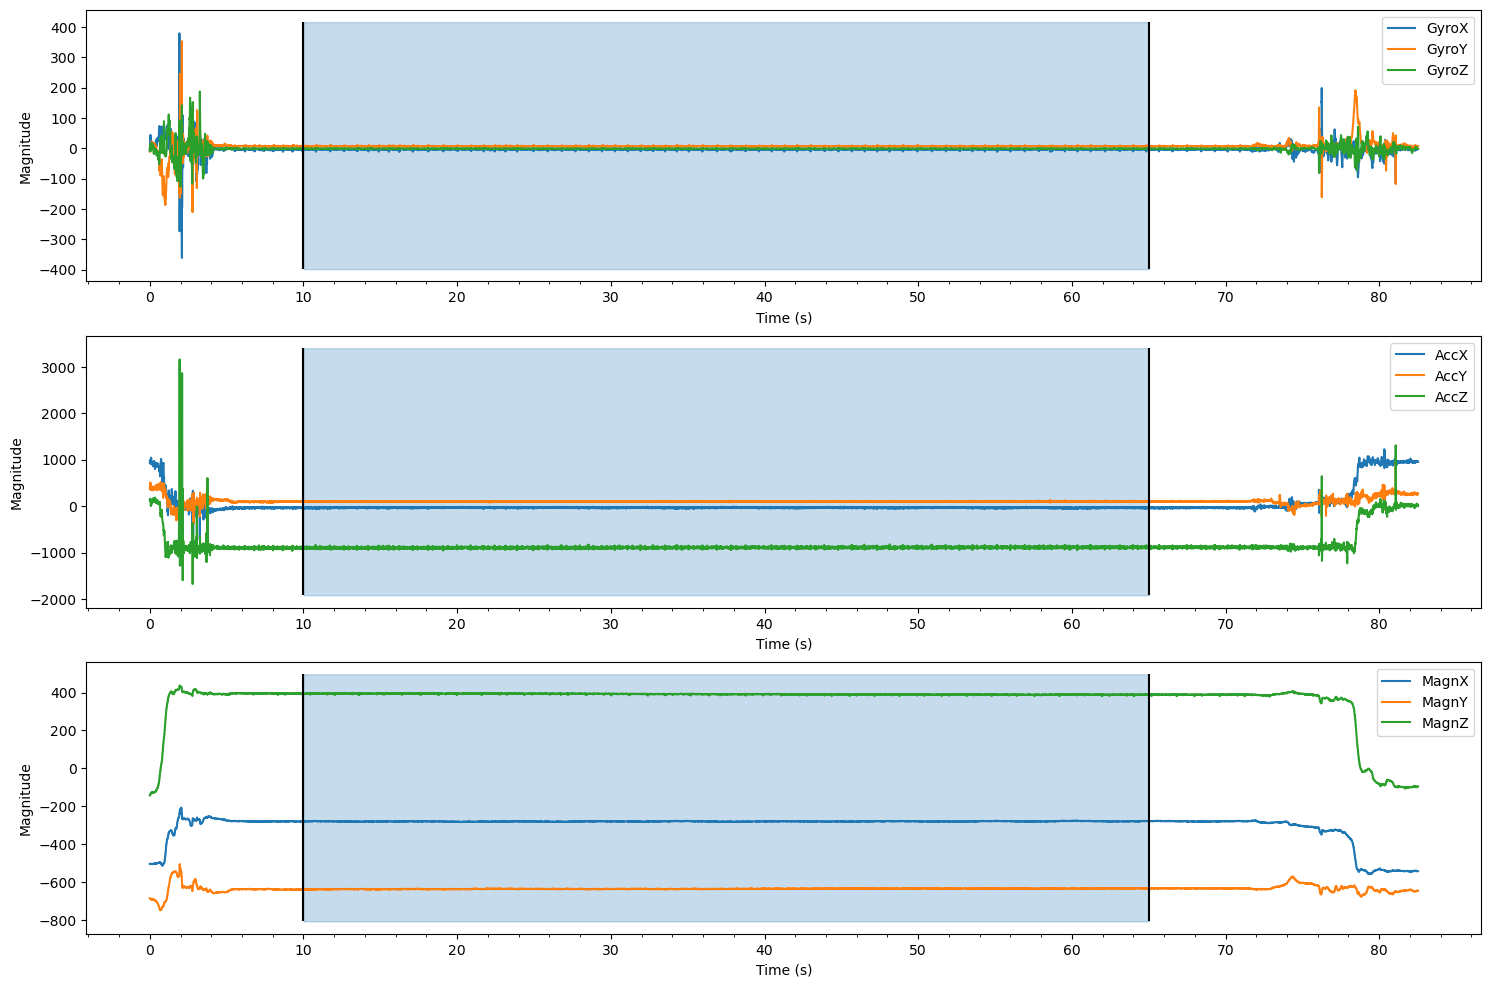

,Log Freq,Timestamp,Abs Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,200,1576222781,10.000,-36.191918,98.305357,-897.115495,-0.486499,7.986364,-1.527557,-278.856972,-639.776198,393.017911
2001,200,1576222781,10.005,-22.684157,97.764133,-915.007862,-0.684972,7.161936,-1.802366,-278.856972,-639.776198,393.017911
2002,200,1576222781,10.010,-31.003173,96.009994,-887.561201,-1.310926,7.284074,-1.817634,-278.021365,-637.071851,389.534964
2003,200,1576222781,10.015,-25.334931,99.274992,-884.079327,-1.295659,7.100867,-1.985573,-278.021365,-637.071851,389.534964
2004,200,1576222781,10.020,-35.980596,103.453468,-867.603353,-1.219323,7.665753,-1.710763,-278.876743,-638.857065,393.896969
...,...,...,...,...,...,...,...,...,...,...,...,...
12996,200,1576222831,64.980,-44.203217,102.317144,-892.706502,-3.371995,6.978730,-1.237481,-277.248552,-631.614362,387.814391
12997,200,1576222831,64.985,-36.631201,102.001043,-892.711324,-3.356728,6.551249,-1.435954,-277.264842,-630.690971,389.568248
12998,200,1576222831,64.990,-28.811253,103.792989,-905.152510,-3.799476,6.902394,-1.359618,-277.264842,-630.690971,389.568248
12999,200,1576222831,64.995,-46.173206,104.746772,-877.948746,-3.814743,6.978730,-1.771832,-278.187608,-630.671977,388.689967


In [7]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
Nvar = len(labels)

T1_CUT = 10     
IT1_CUT = round(T1_CUT * ACQ_FREQ)
T2_CUT = 65 # included
IT2_CUT = round(T2_CUT * ACQ_FREQ) + 1

plt.figure(figsize=(18, 4 * (Nvar // 3)))
for i in range(Nvar // 3):
    ax = plt.subplot(Nvar // 3, 1, i + 1)
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3]], label=labels[i * 3])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 1]], label=labels[i * 3 + 1])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 2]], label=labels[i * 3 + 2])
    ymin, ymax = plt.ylim()
    plt.vlines(x=raw_data.loc[IT1_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")
    plt.vlines(x=raw_data.loc[IT2_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")

    ax.fill_between(raw_data.loc[IT1_CUT: IT2_CUT, "Abs Time"], ymin, ymax, color='C0', alpha=0.25)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.xlabel("Time (s)")
    plt.ylabel("Magnitude")
    plt.legend()

plt.show()
raw_data_cut = raw_data.loc[IT1_CUT: IT2_CUT - 1, :]
raw_data_cut

In [ ]:

fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
for i in range(2):
    for j in range(Nvar):
        if i == 0:
            x_range = raw_data["Abs Time"]
            data_range = raw_data[labels[j]]
        else:
            xmax, xmin = 16, 24
            ixmin, ixmax = (xmax * ACQ_FREQ - 50,  xmin * ACQ_FREQ + 50)
            data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
            x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
            axs[j][i].set_xlim(xmax, xmin)

        axs[j][i].plot(x_range, data_range, label=labels[j]) #c='b' ?
        axs[j][i].set_xlabel("Time [s]")

        if "Acc" in labels[j]:
            axs[j][i].set_ylabel("Linear Acceleration [mg]")
        elif "Gyro" in labels[j]:
            axs[j][i].set_ylabel("Angular Velocity [dps]")
        elif "Magn" in labels[j]:
            axs[j][i].set_ylabel("Magnetic Field [mgauss]")

        # axs[j][i].legend(loc="best")


# Statistical Analysis

Now we print for all the columns remained the mean, standard deviation, minimum, maximum and the 25,50,75 percentiles in the time window we have selected. Then we also normalize the data by subtracting the mean and by dividing for the standard deviation. For the accelerations and the angular velocities the 25 and 75 percentiles are nearly simmetric, so the variables change quite regularly. We notice a higher deviation for the acceleration over X, and the angular velocity along Z. We plot also the normalized data in a 9x9 grid in order to notice some correlation but in our case nothing interesting appears

In [8]:
raw_data_cut.drop(["Log Freq", "Timestamp", "Abs Time"], axis=1).describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000,11001.000000
mean,-34.125429,100.654133,-892.862843,-4.319344,6.651708,-1.586729,-278.723389,-633.791766,391.294005
std,7.033450,5.224951,14.452377,1.425395,0.717895,0.364948,1.204988,1.564649,2.524112
min,-70.523078,71.834825,-959.109087,-12.242224,3.467280,-3.222214,-282.650371,-639.776198,380.808251
25%,-38.758325,97.171078,-901.407869,-4.929247,6.245906,-1.832901,-279.865783,-635.178566,389.537294
50%,-34.010220,100.808275,-893.309854,-4.394896,6.597051,-1.573359,-278.969750,-633.439856,391.293856
75%,-29.448412,104.096712,-885.126901,-3.707873,6.963463,-1.344351,-278.057426,-632.497471,393.908188
max,-8.963639,131.953547,-822.777963,2.231058,10.520715,-0.077176,-274.460483,-629.710597,396.544210


In [9]:
data_std = (raw_data_cut[labels] - np.mean(raw_data_cut[labels], axis=0)) / np.std(raw_data_cut[labels], axis=0)
data_std.insert(0, "Abs Time", raw_data_cut["Abs Time"])
data_std.set_index(np.arange(0, len(data_std)), inplace=True)
display(data_std)

,Abs Time,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,MagnX,MagnY,MagnZ
0,10.000,2.689093,1.859209,0.162144,-0.293822,-0.449551,-0.294266,-0.110863,-3.824949,0.683006
1,10.005,2.549846,0.710761,-0.590898,1.626768,-0.553141,-1.532345,-0.110863,-3.824949,0.683006
2,10.010,2.110682,0.880902,-0.632736,0.443935,-0.888879,0.366852,0.582625,-2.096466,-0.696926
3,10.015,2.121393,0.625690,-1.092929,1.249870,-0.263965,0.607783,0.582625,-2.096466,-0.696926
4,10.020,2.174950,1.412590,-0.339885,-0.263776,0.535787,1.747853,-0.127272,-3.237485,1.031286
...,...,...,...,...,...,...,...,...,...,...
10996,64.980,0.664652,0.455550,0.957024,-1.432902,0.318297,0.010818,1.223999,1.391687,-1.378612
10997,64.985,0.675364,-0.139942,0.413159,-0.356281,0.257796,0.010484,1.210479,1.981872,-0.683739
10998,64.990,0.364735,0.349212,0.622338,0.755592,0.600771,-0.850395,1.210479,1.981872,-0.683739
10999,64.995,0.354024,0.455550,-0.507227,-1.713003,0.783323,1.031995,0.444656,1.994013,-1.031712


# PCA

Now we're compute a PCA (principal component analysis) on the entire dataset (9 columns of data). We select the six components that allow us to maintain the 85% of the variability of the dataset

In [10]:
avls, avts = linalg.eig(np.cov(data_std[labels].T))
sort_perm = np.flip(np.argsort(avls))

avls = np.real_if_close(avls[sort_perm])
avts = avts[:, sort_perm]

var_ratios = avls / np.sum(avls)
print('Eigenvalues:\n', np.round(avls, 4)) #todo tenere la troncatura?
print('Variability ratios:\n', np.round(var_ratios * 100, 2))
print("Eigenvector:")
display(pd.DataFrame(avts, columns=[f"Avt {i}" for i in range(len(avls))]))

Eigenvalues:
 [2.4787 1.7799 1.3701 0.8805 0.7382 0.5773 0.5298 0.4009 0.2454]
Variability ratios:
 [27.54 19.78 15.22  9.78  8.2   6.41  5.89  4.45  2.73]
Eigenvector:


,Avt 0,Avt 1,Avt 2,Avt 3,Avt 4,Avt 5,Avt 6,Avt 7,Avt 8
0,0.182888,0.518853,0.200911,-0.113755,-0.183171,-0.716156,-0.298493,0.087567,0.029009
1,0.124385,0.580960,-0.128268,0.036783,-0.258641,0.244809,0.638616,0.300133,-0.066868
2,0.148762,0.556458,-0.033822,0.000907,0.417231,0.480584,-0.449112,-0.240885,-0.048063
3,0.290740,-0.019744,0.645695,0.098572,-0.027473,0.012302,0.343172,-0.601776,-0.087379
4,-0.418706,0.081714,0.130817,-0.099433,-0.737659,0.289169,-0.302951,-0.186221,-0.191810
5,-0.282156,0.160740,-0.429412,0.655244,-0.001573,-0.273269,0.088747,-0.440214,-0.066845
6,-0.352783,0.120183,-0.231093,-0.708337,0.211525,-0.174252,0.273443,-0.379926,-0.108323
7,-0.460078,0.073331,0.398113,0.167226,0.345991,-0.070861,0.044378,0.325520,-0.603182
8,0.503355,-0.175801,-0.334233,-0.083973,-0.126969,-0.048963,-0.084890,-0.057613,-0.753605


In [11]:
PCA_LABELS = [f"PC{i+1}" for i in range(len(avls))]
data_rot = pd.DataFrame(data=np.dot(avts.T, data_std[labels].T).T, columns=PCA_LABELS)

perc_soil = .85
N_PCA = np.argmax(np.cumsum(var_ratios) >= perc_soil) + 1

print(f'To keep {int(perc_soil * 100)}% of our data we need {N_PCA} of the {len(var_ratios)} principal components')

display(data_rot)

PCA_LABELS = PCA_LABELS[:N_PCA]
data_pca = data_rot[data_rot.columns[:N_PCA]]
data_pca.insert(0, "Abs Time", data_std["Abs Time"])
display(data_pca)


To keep 85% of our data we need 6 of the 9 principal components


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,3.075695,2.073479,-1.551284,-1.032899,-1.999198,-1.189014,0.063028,-0.097831,1.881899
1,3.746452,0.669598,0.351727,-1.671614,-1.965251,-1.400342,0.289974,-0.864770,1.925656
2,1.207398,1.271186,-0.391031,-0.540507,-0.749164,-1.870673,0.796333,-0.525130,1.866565
3,1.013835,0.946276,0.158099,-0.376356,-1.360618,-2.037202,0.945469,-1.197361,1.699668
4,1.782219,1.655941,-2.187663,0.332393,-2.574286,-1.499982,0.041799,-1.079108,0.977814
...,...,...,...,...,...,...,...,...,...
10996,-1.998359,1.689615,-0.113521,-0.742299,0.879743,-0.077483,-0.410998,0.830064,0.073153
10997,-1.729927,0.939818,0.676640,-0.604072,0.933046,-0.569957,-0.198958,0.304033,-0.821209
10998,-1.272213,1.046921,1.676883,-1.039144,0.668515,0.220885,0.313458,0.019259,-0.978377
10999,-2.664835,0.810843,-0.380989,0.510612,-0.011728,-0.630616,-0.022866,1.260179,-0.538782


,Abs Time,PC1,PC2,PC3,PC4,PC5,PC6
0,10.000,3.075695,2.073479,-1.551284,-1.032899,-1.999198,-1.189014
1,10.005,3.746452,0.669598,0.351727,-1.671614,-1.965251,-1.400342
2,10.010,1.207398,1.271186,-0.391031,-0.540507,-0.749164,-1.870673
3,10.015,1.013835,0.946276,0.158099,-0.376356,-1.360618,-2.037202
4,10.020,1.782219,1.655941,-2.187663,0.332393,-2.574286,-1.499982
...,...,...,...,...,...,...,...
10996,64.980,-1.998359,1.689615,-0.113521,-0.742299,0.879743,-0.077483
10997,64.985,-1.729927,0.939818,0.676640,-0.604072,0.933046,-0.569957
10998,64.990,-1.272213,1.046921,1.676883,-1.039144,0.668515,0.220885
10999,64.995,-2.664835,0.810843,-0.380989,0.510612,-0.011728,-0.630616


# Filter

Now we're going to perform a fourier analysis using the scipy fftpack library; in this way we would like to estrapolate the principal frequencies of the data and see if we can see a frequence near the respiratory rate (and also the hearth rate frequency). Firstly we calculate the power and the frequencies and we plot the power w.r.t. the frequency for every variable. In the left column we can see the entire spectrum (with both the respiration's and the hearth's frequencies) while in the right column there is a zoom in the [0,1] frequency

In [ ]:
sig_fft = fft.fftshift(fft.fft(data_pca[PCA_LABELS], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    for j in range(2):
        ax = plt.subplot(N_PCA, 2, i * 2 + j + 1)
        plt.plot(sample_freq, np.abs(sig_fft[:, i]), label=PCA_LABELS[i])
        if j == 0:
            plt.xlim([0, 3])
        else:
            plt.xlim([0, 1])
            plt.xticks(np.arange(0, 1, 0.1))
        
        plt.xlabel("Freq [Hz]")
        plt.ylabel("Power")
        plt.legend(loc="best")
    

In [ ]:
total_FFT = np.sum(np.abs(sig_fft), axis=1)
plt.plot(sample_freq, total_FFT)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.xlim([0,1]);

Let's now perform a wavelet transform analysis

In [ ]:
pywt.dwt_max_level(len(data_pca), "sym5")

In [ ]:
#Filter signal using wavelets
#We used db2, with a high decomposition level 
#as we are interested only in low frequencies but we want to exclude those near zero
#we will thus use the last three detail coefficients to
#cover ranges [0.098, 0.78125] Hz 

lvl = 0
if file_name == "center_sternum.txt":
    lvl = 10
else:
    lvl = 9

coeffs = pywt.wavedec(data_pca[PCA_LABELS], "sym5", level=lvl, axis=0)
coeffs[0] = np.zeros_like(coeffs[0])
for i in range(3, lvl + 1):
    coeffs[i] = np.zeros_like(coeffs[i])

A10 = pywt.waverec(coeffs, "sym5", axis=0)


In [ ]:
#plot only approximation wavelet
fig, axs = plt.subplots(nrows=N_PCA, ncols=2, figsize=(18, N_PCA*5))

for i in range(N_PCA):
    for j in range(2):
        #axs[i][j].plot(data_std["Abs Time"], data_std[labels[i]], label=("Original "+labels[i]))
        #axs[i][j].plot(data_std["Abs Time"], filtered[i], label=("Butterworth "+labels[i]))
        #axs[i][j].plot(data_std["Abs Time"], A7[i][:-1],  label=("Butterworth+Wavelet "+labels[i]))
        axs[i][j].plot(data_pca["Abs Time"], A10[:-1, i], label=("Wavelet "+PCA_LABELS[i]))
        if j == 1:
            axs[i][j].set_xlim([20,24])
        
        axs[i][j].set_xlabel("Time [s]")
        axs[i][j].set_ylabel("Magnitude") # ???
        axs[i][j].legend(loc="best")
    

In [ ]:
sig_fft_wt = fft.fftshift(fft.fft(A10[:-1, :], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    for j in range(2):
        ax = plt.subplot(N_PCA, 2, i * 2 + j + 1)
        plt.plot(sample_freq, np.abs(sig_fft[:, i]), label=PCA_LABELS[i])
        plt.plot(sample_freq, np.abs(sig_fft_wt[:, i]),
                 label="Approximated " + PCA_LABELS[i])
        if j == 0:
            plt.xlim([0, 3])
        else:
            plt.xlim([0, 1])
            plt.xticks(np.arange(0, 1, 0.1))

        plt.xlabel("Freq [Hz]")
        plt.ylabel("Power")
        plt.legend(loc="best")


# Metrics

### Detection of the peaks

In [ ]:
A10=A10.T
peaks = []
valleys = []
for i in range(len(A10)):
    temp_signal = A10[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal)
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks.append(temp_signal[temp_peaks])
    peaks.append(data_std['Abs Time'].values[temp_peaks])
    valleys.append(temp_signal[temp_valleys])
    valleys.append(data_std['Abs Time'].values[temp_valleys])
    
fig, ax = plt.subplots(len(A10), 1, figsize=(20, 15))
for i in range(1, len(peaks), 2):    
    ax[int(i/2)].plot(data_std['Abs Time'], A10[int(i/2)][:-1])
    ax[int(i/2)].plot(peaks[i], peaks[i-1], 'x')

### Improve peak detection

In [ ]:
avg_peak_dist = []
for i in range(1, len(peaks), 2):    
    avg_peak_dist.append(len(data_std['Abs Time']) / len(peaks[i]))
print(avg_peak_dist)

sign_amp = []
for i in range(1, len(peaks), 2):
    temp_sign_amp = []    
    for j in range(np.min([len(peaks[i]), len(valleys[i])])):
        temp_peaks = np.array(peaks[i-1])
        temp_valleys = np.array(valleys[i-1])
        temp_sign_amp.append(0.5*np.abs(temp_peaks[j] + temp_valleys[j]))
    sign_amp.append(temp_sign_amp)

avg_sign_amp = np.empty(shape=(len(A10)))
for i,x  in enumerate(sign_amp):
    avg_sign_amp[i] = np.mean(x)

height_perc = .6
distance_perc = .7
peaks_refined = []
valleys_refined = []
for i in range(len(A10)):
    temp_signal = A10[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal, height = height_perc * avg_sign_amp[i], distance = distance_perc * avg_peak_dist[i])
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks_refined.append(temp_signal[temp_peaks])
    peaks_refined.append(data_std['Abs Time'].values[temp_peaks])
    valleys_refined.append(temp_signal[temp_valleys])
    valleys_refined.append(data_std['Abs Time'].values[temp_valleys])

fig, ax = plt.subplots(len(A10), 1, figsize=(20, 15))
for i in range(1, len(peaks_refined), 2):    
    ax[int(i/2)].plot(data_std['Abs Time'], A10[int(i/2)][:-1])
    ax[int(i/2)].plot(peaks_refined[i], peaks_refined[i-1], 'x')
    ax[int(i/2)].axhline(avg_sign_amp[int(i/2)] * height_perc, color='g')
    # ax[int(i/2)].plot(valleys_refined[i], valleys_refined[i-1], 'x')

### Generate histogram and perform gaussian fit to estimate RR

In [ ]:
time_dist = []
for i in range(1, len(peaks_refined), 2):
    temp_time_dist = []    
    for j in range(1, len(peaks_refined[i])):
        temp_peaks_time = peaks_refined[i]
        temp_time_dist.append(temp_peaks_time[j]-temp_peaks_time[j-1])
    time_dist.append(temp_time_dist)

time_dist = np.concatenate(time_dist)
print(len(time_dist))
original_mean = np.mean(time_dist)
print(original_mean)
original_std = np.std(time_dist)
print(original_std)

fig, ax = plt.subplots(figsize=(8,6))
bins = ax.hist(x=time_dist)
lower_sigma_tol = 2
upper_sigma_tol = 3
# ax.axvline(np.mean(time_dist) - lower_sigma_tol*original_std, color='r')
# ax.axvline(np.mean(time_dist) + upper_sigma_tol*original_std, color='r')

bin_centers = (bins[1][:-1] + bins[1][1:]) / 2
bin_counts = bins[0]

def myround(x):
    return round(x,1)

ax.set_xticks(bin_centers)
_=ax.set_xticklabels(map(myround,bin_centers))

def my_gaus(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x-mu)/sigma) ** 2)

params, params_cov = optimize.curve_fit(my_gaus, bin_centers, bin_counts, p0=[1, np.mean(time_dist), np.std(time_dist)], absolute_sigma=True, bounds=(0,[100, 100, 100]))
fit_domain = np.sort(np.random.uniform(np.min(bin_centers), np.max(bin_centers), 1000))
_=ax.plot(fit_domain, my_gaus(fit_domain, *params))

print('Fit parameters:\n',params)
print('Fit parameters errors:\n', np.sqrt(np.diag(params_cov)))

**Alternative method without filter**

When we have no filter we can consider the frequencies' range [0.1,0.4] and compute the respiration rate as the mean of the frequencies of the three max power in the fourier analysis for each of the six principal components

In [ ]:
sample_freqi = (sample_freq > 0.1) & (sample_freq < 0.4)
power_fft = np.abs(sig_fft)

freqi_maxs = np.argmax(power_fft[sample_freqi, :], axis=0)
freq_maxs = sample_freq[sample_freqi][freqi_maxs]
RR = np.mean(freq_maxs)

print(f"RPM is: {RR * 60:.2f}")

# Conclusions

## EXTRA

In [ ]:
#filter signal with Butterworth bandpass filter in [0.1,0.5] Hz range

freq=200
filtered = np.zeros((Nvar,len(data_std)))
sos = signal.butter(4, [0.1, 0.8], 'bandpass', fs=freq, output='sos')
for i in range(Nvar):
    filtered[i] = signal.sosfilt(sos, data_std[labels[i]])
    

In [ ]:
#plot filtered Gyro and Acc
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data_std["Abs Time"], data_std[labels[j]], label=labels[j])
        axs[j][i].plot(data_std["Abs Time"], filtered[j],         label=("Filtered "+labels[j]))
        if i == 1:
            axs[j][i].set_xlim([20,24])

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [ ]:
#calculate spectrum after filtering
sig_fft_filt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_filt[i] = fftpack.fft(filtered[i])

power_filt = np.abs(sig_fft_filt)

In [ ]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],      label=labels[j])
        axs[j][i].plot(sample_freq, power_filt[j], label=("Filtered "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")

In [ ]:
#Filter signal using wavelets
#We used db6 as it is smooth, with a decomposition level=7 
#as we are interested only in low frequencies, and the approximate coefficients at level J
#cover ranges [0, freq/2^(J+1)], so or the last decomposition [0, 0.78125] Hz
lvl = 0
if file_name == "center_sternum.txt":
    lvl = 7
else:
    lvl = 6
    
A7 = np.zeros((Nvar, len(data_std)+1))
for i in range(Nvar):
    coeffs = pywt.wavedec(filtered[i], "db6", level=lvl)
    for l in range(1, lvl+1):
        coeffs[l] = np.zeros_like(coeffs[l])
    A7[i] = pywt.waverec(coeffs, "db6") 
    


In [ ]:
#plot only approximation wavelet
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(data_std["Abs Time"], A7[j][:-1], label=labels[j])
        if i == 1:
            axs[j][i].set_xlim([20,24])
        

for ax in axs.flatten():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Magnitude")
    ax.legend(loc="best")

In [ ]:
#calculate spectrum after wavelet
sig_fft_wt = 1j*np.zeros((Nvar, len(data_std)))

for i in range(Nvar):
    sig_fft_wt[i] = fftpack.fft(A7[i][:-1])

power_wt = np.abs(sig_fft_wt)

In [ ]:
#plot filtered spectrum
fig, axs = plt.subplots(nrows=Nvar, ncols=2, figsize=(18,Nvar*5))

for i in range(2):
    for j in range(Nvar):
        axs[j][i].plot(sample_freq, power[j],    label=labels[j])
        axs[j][i].plot(sample_freq, power_wt[j], label=("Approximated "+labels[j]))
        if i == 0:
            axs[j][0].set_xlim([0,3])
        else:
            axs[j][i].set_xlim([0,1])
            axs[j][i].set_xticks(np.arange(0,1,0.1))
        

for ax in axs.flatten():
    ax.set_xlabel("Freq [Hz]")
    ax.set_ylabel("Power")
    ax.legend(loc="best")